In [400]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [401]:
import numpy as np
import scipy.stats as stats
import matplotlib as mpl
from dataloader import load_data
import matplotlib.pyplot as plt
import seaborn as sns
from evaluate import *

In [488]:
sns.set_style("ticks")
dark_palette = np.array(sns.color_palette("dark", 8))[np.array([0,2,1,3,4,5,6,7]),:]
deep_palette = np.array(sns.color_palette("deep", 8))[np.array([0,2,1,3,4,5,6,7]),:]
sns.set_palette(dark_palette)
plt_colors = sns.color_palette()
mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.direction"] = "in"
mpl.rcParams.update({'font.size': 12})

In [489]:
X, y, w, t, cens = {}, {}, {}, {}, {}

In [537]:
buckets_ml, buckets_conv, arrs_ml, arrs_conv = {}, {}, {}, {}
pvals_ml, pvals_conv = {}, {}
cox = {}
framingham = {}
ascvd = {}

In [560]:
pred_rr_ml = {}
pred_rr_conv = {}

In [561]:
for dataset in ("combined", "sprint", "accord"):
  
  X[dataset] = np.load("results/xlearner/%s/X.npy" % dataset)
  w[dataset] = np.load("results/xlearner/%s/w.npy" % dataset)
  y[dataset] = np.load("results/xlearner/%s/y.npy" % dataset)
  t[dataset] = np.load("results/xlearner/%s/t.npy" % dataset)
  cens[dataset] = np.load("results/xlearner/%s/cens.npy" % dataset)
  
  cox[dataset] = np.load("results/baselines/%s/coxph.npy" % dataset)
  framingham[dataset] = np.load("results/baselines/%s/framingham.npy" % dataset)
  ascvd[dataset] = np.load("results/baselines/%s/ascvd.npy" % dataset)
  
  pred_rr_ml[dataset] = np.load("results/xlearner/%s/pred_rr.npy" % dataset)
  pred_rr_conv[dataset] = np.load("results/logreg/%s/pred_rr.npy" % dataset)
  
  buckets_ml[dataset] = np.load("results/xlearner/%s/buckets.npy" % dataset)
  arrs_ml[dataset] = np.load("results/xlearner/%s/arrs.npy" % dataset).item()
  pvals_ml[dataset] = np.load("results/xlearner/%s/pvals.npy" % dataset)
  buckets_conv[dataset] = np.load("results/logreg/%s/buckets.npy" % dataset)
  arrs_conv[dataset] = np.load("results/logreg/%s/arrs.npy" % dataset).item()
  pvals_conv[dataset] = np.load("results/logreg/%s/pvals.npy" % dataset)

In [562]:
def calc_corr_in_pred_rr(dataset):
  print(stats.pearsonr(pred_rr_ml[dataset], pred_rr_conv[dataset]))

In [563]:
calc_corr_in_pred_rr("combined")

(0.3174033616414525, 4.90819966e-316)


In [564]:
def forest_plot(dataset):
  n_trials = len(arrs_ml[dataset][BENEFIT_ASSIGNMENT])
  buckets, risk_reductions, lengths = [], [], []
  buckets += [1] * n_trials
  risk_reductions += arrs_ml[dataset][BENEFIT_ASSIGNMENT]
  lengths.append(np.sum(buckets_ml[dataset] == BENEFIT_ASSIGNMENT))
  buckets += [2] * n_trials
  risk_reductions += arrs_conv[dataset][BENEFIT_ASSIGNMENT]
  lengths.append(np.sum(buckets_conv[dataset] == BENEFIT_ASSIGNMENT))
  buckets += [4] * n_trials
  risk_reductions += arrs_ml[dataset][NO_BENEFIT_ASSIGNMENT]
  lengths.append(np.sum(buckets_ml[dataset] == NO_BENEFIT_ASSIGNMENT))
  buckets += [5] * n_trials
  risk_reductions += arrs_conv[dataset][NO_BENEFIT_ASSIGNMENT]
  lengths.append(np.sum(buckets_conv[dataset] == NO_BENEFIT_ASSIGNMENT))
  buckets = np.array(buckets)
  risk_reductions = np.array(risk_reductions)
  ytick_labels = [
    "$\mathbf{Benefit}$",
    "    Machine Learning",
    "    Conventional",
    "$\mathbf{No\ benefit}$   ",
    "    Machine Learning", 
    "    Conventional"]
  ytick_locs = [-0, -1,-1.5,-3,-4,-4.5]
  fig = plt.figure(figsize=(12, 4), tight_layout=True)
  pvals = {
    1: pvals_ml[dataset][0],
    2: pvals_conv[dataset][0],
    4: pvals_ml[dataset][1],
    5: pvals_conv[dataset][1]
  }
  minsofar, maxsofar = 0, 0
  for i, b in enumerate([1,2,4,5]):
    rng = get_range(risk_reductions[buckets == b])
    minsofar = min(minsofar, np.min(rng))
    maxsofar = max(maxsofar, np.max(rng))
    plt.plot(rng, [ytick_locs[b]] * 3, "-|", 
             color=plt_colors[0] if b == 1 or b == 4 else plt_colors[1])
    plt.plot([rng[1]], ytick_locs[b], "D", 
             color=plt_colors[0] if b == 1 or b == 4 else plt_colors[1])
  for i, b in enumerate([1,2,4,5]):
    rng = get_range(risk_reductions[buckets == b])
    if pvals[b] < 0.01:
        plt.text(maxsofar + 0.01, ytick_locs[b], 
                 "{:.4f} [{:.4f} {:.4f}], $P < 0.01$, $N$ = {}".format(
                   rng[1], rng[0], rng[2], lengths[i]))
    else:
        plt.text(maxsofar + 0.01, ytick_locs[b], 
                 "{:.4f} [{:.4f} {:.4f}], $P$ = {:.2f}, $N$ = {}".format(
                   rng[1], rng[0], rng[2], pvals[b], lengths[i]))
  ax = fig.get_axes()[0]
  ax.set_yticks([-0, -1,-1.5,-3,-4,-4.5])
  r = ax.set_yticklabels(ytick_labels, ha = 'left')
  plt.draw()
  ax.tick_params(axis=u'y', which=u'both',length=0)
  yax = ax.get_yaxis()
  pad = max(T.label.get_window_extent().width + 5 for T in yax.majorTicks)
  yax.set_tick_params(pad=pad)
  plt.xlabel("Average Risk Reduction")
  plt.xlim([-0.08, 0.16])
  plt.ylim([-5.9,0.5])
  plt.axvline(x=0.0, linestyle="--", color="grey")
  plt.savefig("./img/{}_forest_plot.pdf".format(dataset))

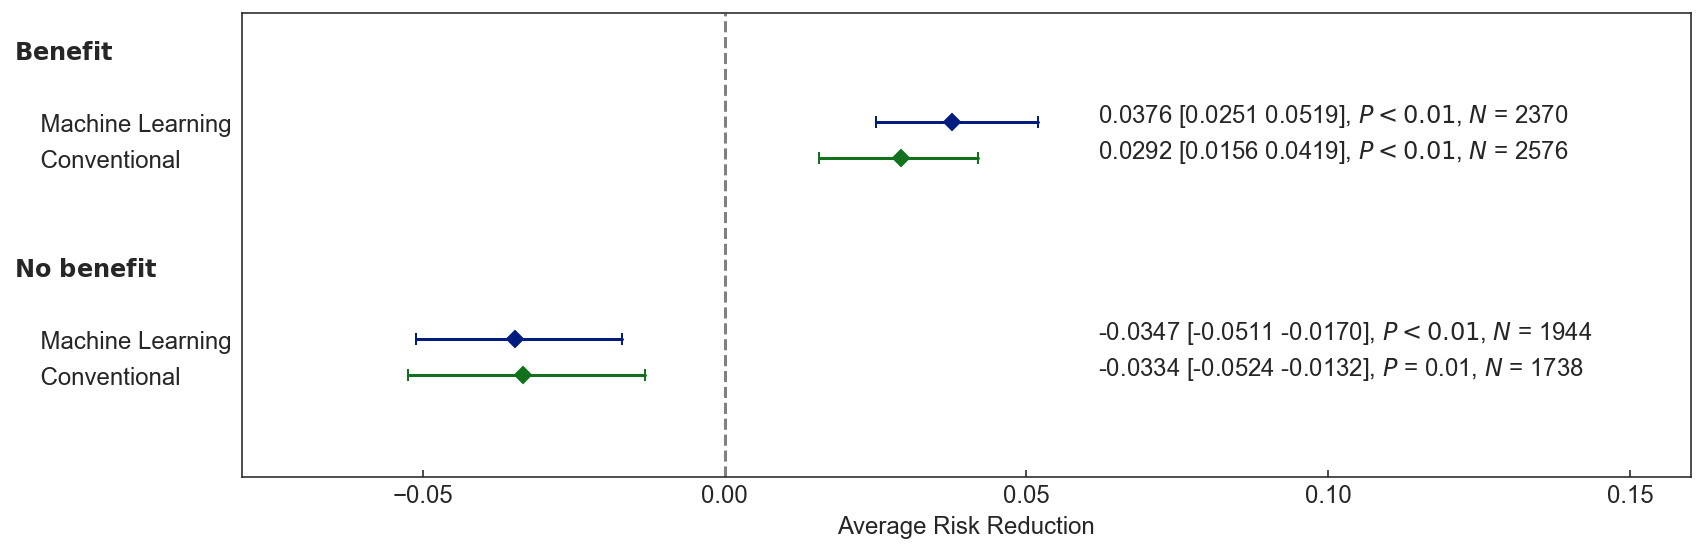

In [566]:
forest_plot("accord")

In [510]:
def plot_expected_vs_obs_rr(dataset, n_bins=5, cens_time=365.25 * 3, bin_strategy="rr"):
  plt.figure(figsize=(12, 4))
  plt.subplot(1,2,1)
  rss, slope, intercept, pred_rr, obs_rr, = calibration(pred_rr_ml[dataset], 
                                                        y[dataset],
                                                        w[dataset], 
                                                        t[dataset],
                                                        cens_time, n_bins=n_bins)
  plt.scatter(pred_rr, obs_rr, alpha=0.5, color=plt_colors[0])
  abline_values = [slope * i + intercept for i in [-0.15, 0.25]]
  plt.plot([-0.15, 0.25], abline_values, '--', color=plt_colors[0])
  plt.title("Machine Learning", fontsize=12, fontweight="bold")
  plt.xlim([-0.15,0.20])
  plt.ylim([-0.15,0.20])
  plt.text(-0.12, 0.15, "Slope: {:.2f}, Intercept: {:.2f}".format(slope, intercept))
  plt.xlabel("Predicted ARR")
  plt.ylabel("Observed ARR")
  plt.plot((-0.3,0.3), (-0.3, 0.3), "--", color="grey")
  plt.subplot(1,2,2)
  rss, slope, intercept, pred_rr, obs_rr, = calibration(pred_rr_conv[dataset], 
                                                        y[dataset],
                                                        w[dataset], 
                                                        t[dataset],
                                                        cens_time, n_bins=n_bins)
  rss = np.sum((np.array(obs_rr) - np.array(pred_rr)) ** 2)
  plt.scatter(pred_rr, obs_rr, alpha=0.5, color=plt_colors[1])
  abline_values = [slope * i + intercept for i in [-0.15, 0.25]]
  plt.plot([-0.15, 0.25], abline_values, '--', color=plt_colors[1])
  plt.title("Conventional", fontsize=12, fontweight="bold")
  plt.xlim([-0.15,0.20])
  plt.ylim([-0.15,0.20])
  plt.xlabel("Predicted ARR")
  plt.ylabel("Observed ARR")
  plt.text(-0.12, 0.15, "Slope: {:.2f}, Intercept: {:.2f}".format(slope, intercept))
  plt.plot((-0.3,0.3), (-0.3, 0.3), "--", color="grey")
  plt.savefig("./img/{}_calibration_curve_by_pred_risk.pdf".format(dataset))

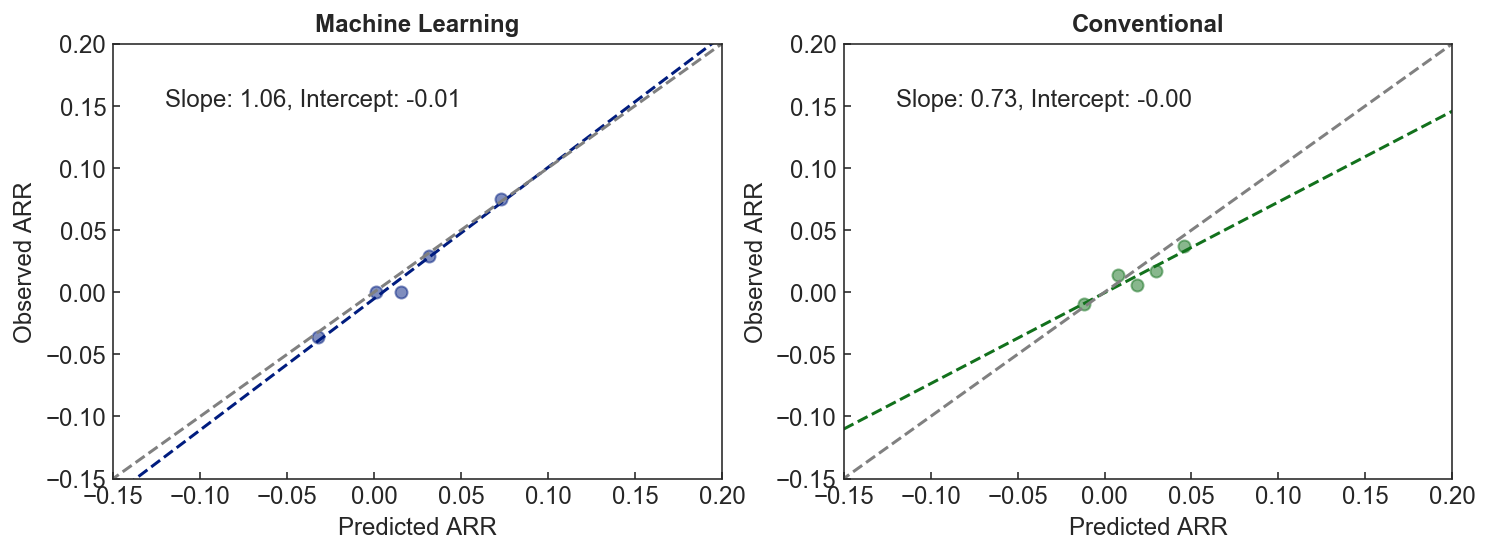

In [511]:
plot_expected_vs_obs_rr("combined", bin_strategy="rr")

In [542]:
def plot_pred_rr_against_baseline_decile(dataset, baseline_risk=cox, n_bins=10):
  bins = np.percentile(baseline_risk[dataset], q=np.linspace(0, 100, n_bins + 1))
  baseline_decile = np.linspace(0, 100, n_bins + 1)[np.digitize(baseline_risk[dataset], bins[:-1]) - 1]
  plt.figure(figsize=(10, 4))
  plt.axhline(y=0.0, linestyle="--", color="grey")
  sns.boxplot(x=np.r_[baseline_decile, baseline_decile] / 10 + 1, 
              y=np.r_[pred_rr_ml[dataset], pred_rr_conv[dataset]], 
              hue=np.r_[["Machine Learning"] * len(pred_rr_ml[dataset]), 
                        ["Conventional"] * len(pred_rr_conv[dataset])], 
              palette=deep_palette,
              showfliers=False)
  plt.ylabel("Predicted ARR")
  plt.xlabel("Baseline Risk Decile")
  plt.ylim((-0.15, 0.20))
  plt.savefig("./img/{}_pred_rr_baseline_decile.pdf".format(dataset))

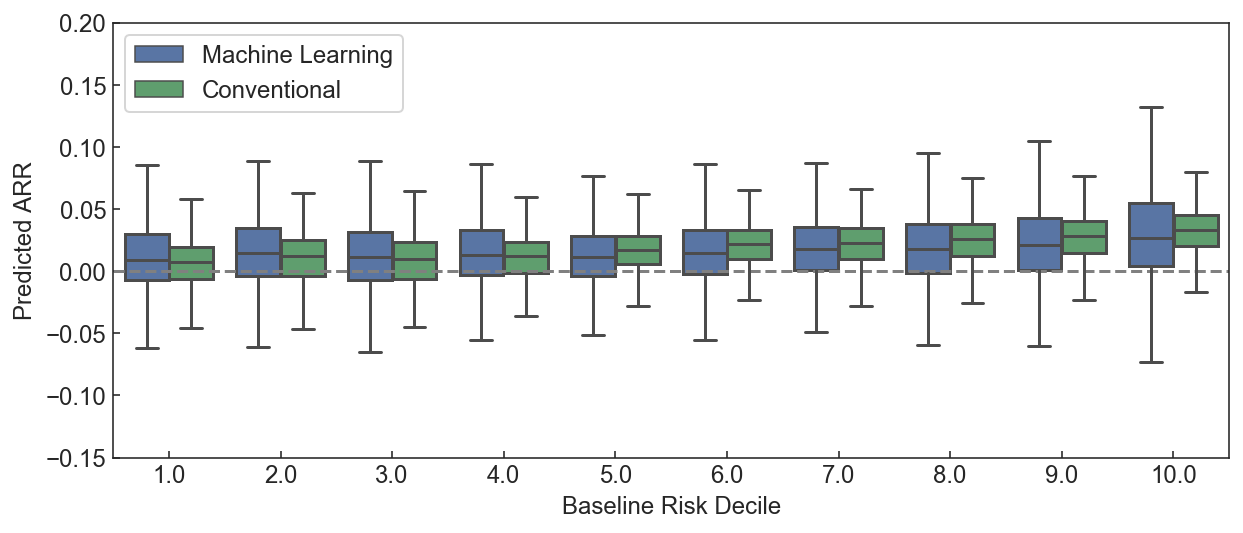

In [555]:
plot_pred_rr_against_baseline_decile("combined", baseline_risk=framingham)

In [567]:
def calc_baseline_decile_table(dataset, baseline_risk=cox, n_bins=10):
  bins = np.percentile(baseline_risk[dataset], q=np.linspace(0, 100, n_bins + 1))
  baseline_decile = np.linspace(0, 100, n_bins + 1)[np.digitize(baseline_risk[dataset], bins[:-1]) - 1]
  for i in sorted(list(set(baseline_decile))):
    u = pred_rr_ml["combined"][baseline_decile == i]
    v = pred_rr_conv["combined"][baseline_decile == i]
    print(f"{int(i / 10 + 1)},{np.percentile(u, 50):.4f},{np.percentile(u, 25):.4f},{np.percentile(u, 75):.4f},{np.percentile(v, 50):.4f},{np.percentile(v, 25):.4f},{np.percentile(v, 75):.4f}")

In [568]:
calc_baseline_decile_table("combined", baseline_risk=ascvd)

1,0.0094,-0.0058,0.0267,0.0010,-0.0115,0.0134
2,0.0089,-0.0059,0.0273,0.0081,-0.0054,0.0200
3,0.0122,-0.0040,0.0298,0.0140,0.0016,0.0259
4,0.0136,-0.0034,0.0298,0.0181,0.0052,0.0292
5,0.0157,0.0000,0.0338,0.0200,0.0070,0.0314
6,0.0157,-0.0020,0.0361,0.0209,0.0084,0.0333
7,0.0142,-0.0038,0.0360,0.0215,0.0103,0.0339
8,0.0206,0.0006,0.0409,0.0255,0.0118,0.0379
9,0.0227,0.0011,0.0453,0.0287,0.0157,0.0398
10,0.0280,0.0019,0.0582,0.0334,0.0200,0.0464


In [517]:
def plot_predicted_rr(dataset):
  plt.figure(figsize=(8, 4))
  pred_rr = pred_rr_ml[dataset]
  sns.kdeplot(pred_rr, label="Machine Learning", shade=True)
  pred_rr = pred_rr_conv[dataset]
  sns.kdeplot(pred_rr, label="Conventional", shade=True)
  plt.ylabel("Density")
  plt.xlabel("Predicted absolute risk reduction")
  plt.xlim([-0.15, 0.15])
  plt.legend()
  plt.savefig("./img/{}_pred_rr_distributions.pdf".format(dataset))

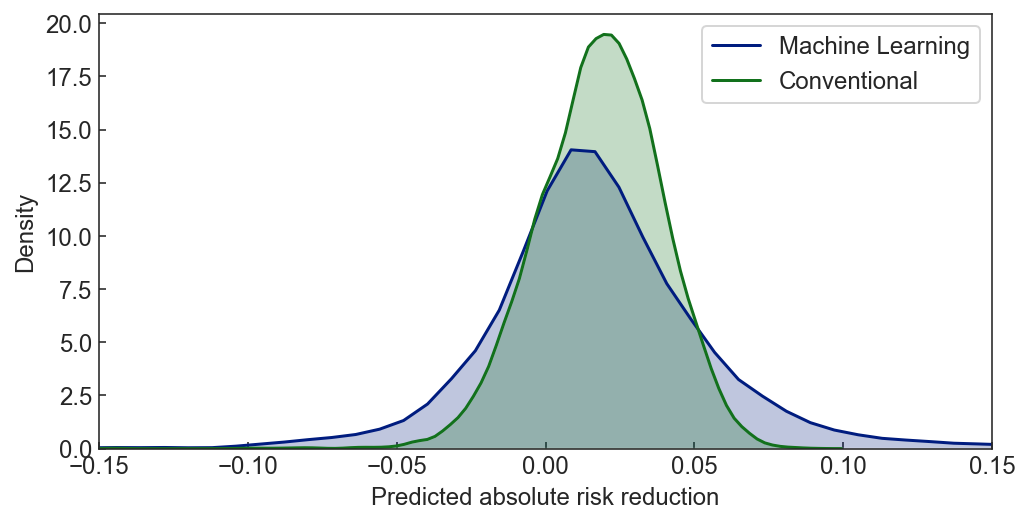

In [518]:
plot_predicted_rr("combined")

In [519]:
def calculate_summary_stats(dataset, bucket=True):
  cols = load_data("accord")["cols"]
  if bucket:
    print("== ml [BEN | NOEFF]")
    print(sum(pred_rr_ml[dataset] > 0))
    print(sum(pred_rr_ml[dataset] <= 0))
    for i, col in enumerate(cols):
      ben = X[dataset][:,i][pred_rr_ml[dataset] > 0]
      noeff = X[dataset][:,i][pred_rr_ml[dataset] <= 0]
      print("{}:,{:.2f} ({:.2f}),{:.2f} ({:.2f})".format(col, ben.mean(), ben.std(),
                                                           noeff.mean(), noeff.std()))
    print("== conv [BEN | NOEFF]")
    print(sum(pred_rr_conv[dataset] > 0))
    print(sum(pred_rr_conv[dataset] <= 0))
    for i, col in enumerate(cols):
      ben = X[dataset][:,i][pred_rr_conv[dataset] > 0]
      noeff = X[dataset][:,i][pred_rr_conv[dataset] <= 0]
      print("{}:,{:.2f} ({:.2f}),{:.2f} ({:.2f})".format(col, ben.mean(), ben.std(),
                                                              noeff.mean(), noeff.std()))
  else:
    for i, col in enumerate(cols):
      print("{}:,{:.2f} ({:.2f})".format(col, X[dataset][:,i].mean(),
                                              X[dataset][:,i].std()))

In [532]:
calculate_summary_stats("combined", bucket=True)

== ml [BEN | NOEFF]
9763
3841
AGE:,66.67 (9.13),65.34 (8.07)
FEMALE:,0.39 (0.49),0.43 (0.50)
RACE_BLACK:,0.30 (0.46),0.26 (0.44)
hisp:,0.09 (0.29),0.10 (0.30)
SBP.y:,141.20 (16.06),135.67 (13.75)
DBP.y:,78.93 (11.23),73.58 (11.16)
N_AGENTS:,1.78 (1.06),1.81 (1.05)
currentsmoker:,0.10 (0.30),0.07 (0.26)
formersmoker:,0.44 (0.50),0.46 (0.50)
ASPIRIN:,0.51 (0.50),0.53 (0.50)
STATIN:,0.45 (0.50),0.65 (0.48)
SCREAT:,1.01 (0.31),1.04 (0.35)
CHR:,191.70 (41.51),189.33 (43.54)
HDL:,51.78 (14.29),48.27 (14.47)
TRR:,133.13 (79.20),180.02 (191.34)
BMI:,30.69 (5.79),30.58 (5.73)
diabetes:,0.27 (0.44),0.50 (0.50)
== conv [BEN | NOEFF]
11029
2575
AGE:,67.51 (8.85),61.08 (6.79)
FEMALE:,0.34 (0.47),0.66 (0.47)
RACE_BLACK:,0.29 (0.45),0.28 (0.45)
hisp:,0.06 (0.23),0.26 (0.44)
SBP.y:,140.66 (15.61),135.25 (15.01)
DBP.y:,78.15 (11.62),74.30 (10.19)
N_AGENTS:,1.80 (1.06),1.76 (1.02)
currentsmoker:,0.10 (0.30),0.07 (0.26)
formersmoker:,0.47 (0.50),0.35 (0.48)
ASPIRIN:,0.53 (0.50),0.47 (0.50)
STATIN:,0.43 (

In [521]:
calculate_summary_stats("combined", bucket=False)

AGE:,66.29 (8.86)
FEMALE:,0.40 (0.49)
RACE_BLACK:,0.29 (0.45)
hisp:,0.09 (0.29)
SBP.y:,139.64 (15.64)
DBP.y:,77.42 (11.47)
N_AGENTS:,1.79 (1.05)
currentsmoker:,0.09 (0.29)
formersmoker:,0.45 (0.50)
ASPIRIN:,0.51 (0.50)
STATIN:,0.51 (0.50)
SCREAT:,1.02 (0.32)
CHR:,191.03 (42.11)
HDL:,50.79 (14.43)
TRR:,146.37 (123.63)
BMI:,30.66 (5.77)
diabetes:,0.33 (0.47)


In [530]:
def plot_matching_patient_pairs(dataset):
  random.seed(1)
  plt.figure(figsize=(11, 4))
  plt.subplot(1,2,1)
  tuples = list(zip(pred_rr_ml[dataset][cens[dataset] == 0], 
                    y[dataset][cens[dataset] == 0], 
                    w[dataset][cens[dataset] == 0]))
  untreated = list(filter(lambda t: t[2] == 0, tuples))
  treated = list(filter(lambda t: t[2] == 1, tuples))
  if len(treated) < len(untreated):
    untreated = random.sample(untreated, len(treated))
  if len(untreated) < len(treated):
    treated = random.sample(treated, len(untreated))
  assert len(untreated) == len(treated)
  untreated = sorted(untreated, key=lambda t: t[0])
  treated = sorted(treated, key=lambda t: t[0])
  plt.scatter(np.array(treated)[:,0], np.array(untreated)[:,0], marker=".", alpha=1e-2)
  plt.plot((-0.3, 0.3), (-0.3, 0.3), "--", color="grey")
  plt.xlabel("Predicted ARR, intensive arm")
  plt.ylabel("Predicted ARR, standard arm")
  plt.ylim(-0.3, 0.3)
  plt.xlim(-0.3, 0.3)
  plt.title("Machine Learning", fontsize=12, fontweight="bold")
  plt.subplot(1,2,2)
  tuples = list(zip(pred_rr_conv[dataset], y[dataset], w[dataset]))
  untreated = list(filter(lambda t: t[2] == 0, tuples))
  treated = list(filter(lambda t: t[2] == 1, tuples))
  if len(treated) < len(untreated):
    untreated = random.sample(untreated, len(treated))
  if len(untreated) < len(treated):
    treated = random.sample(treated, len(untreated))
  assert len(untreated) == len(treated)
  untreated = sorted(untreated, key=lambda t: t[0])
  treated = sorted(treated, key=lambda t: t[0])
  plt.scatter(np.array(treated)[:,0], np.array(untreated)[:,0], marker=".", alpha=2e-3, color=plt_colors[1])
  plt.plot((-0.3, 0.3), (-0.3, 0.3), "--", color="grey")
  plt.xlabel("Predicted ARR, intensive arm")
  plt.ylabel("Predicted ARR, standard arm")
  plt.title("Conventional", fontsize=12, fontweight="bold")
  plt.ylim(-0.3, 0.3)
  plt.xlim(-0.3, 0.3)
  plt.savefig("./img/{}_matching_patient_pairs.pdf".format(dataset))

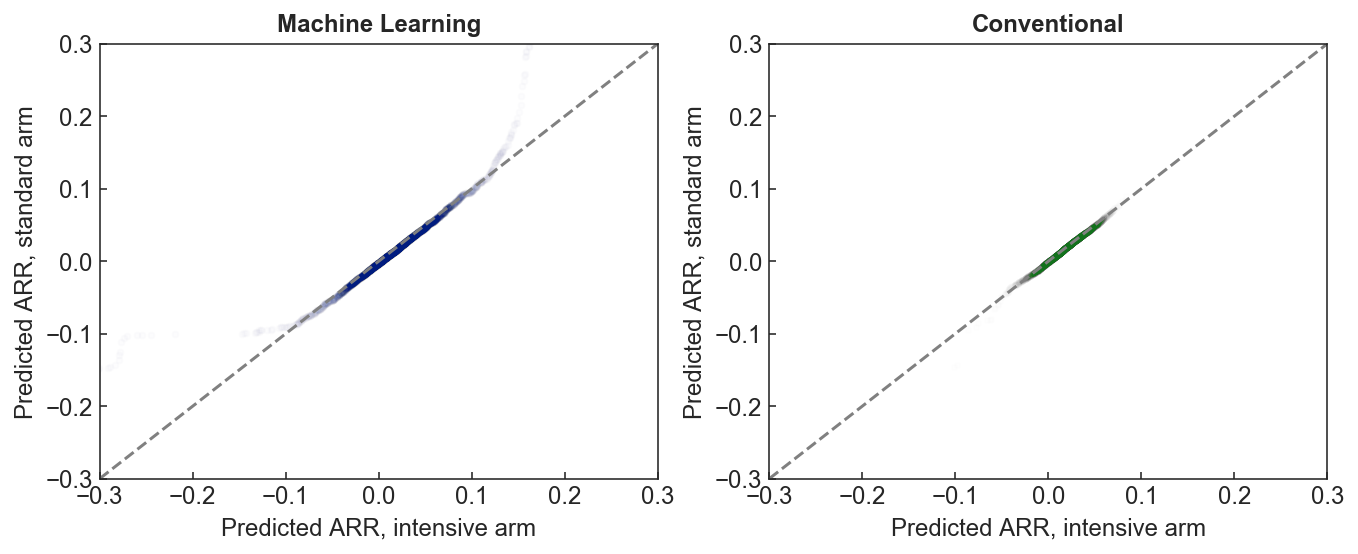

In [531]:
plot_matching_patient_pairs("combined")